In [2]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import os
import matplotlib as mpl
seaborn.set_context('talk')

In [3]:
with open('active_learning_data/dataset_names.txt') as f:
    names = f.readlines()
    names = [n[:-1] for n in names]
print(names)
print(len(names))

['antibacterial', 'anticancer', 'antifungal', 'antiHIV', 'antiMRSA', 'antiparasital', 'antiviral', 'hemolytic', 'soluble', 'shp2', 'tula2', 'human']
12


(0.6644296597633136, 0.22325986649409724)

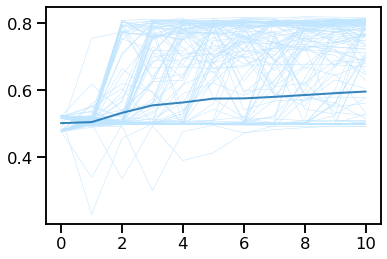

In [4]:
def plot_condition(ax, label, color, linestyle, location, trace=True, horizontal=False):
    # load lines
    avg = None
    aucs = []
    # mimic how an alpha would blend,
    # but don't use alpha so that we don't create
    # false "mean lines"
    base_color = mpl.colors.to_rgb(color)
    base_hsv = mpl.colors.rgb_to_hsv(base_color)
    base_hsv[1] *= 0.3
    base_hsv[2] = 1.0
    trace_color = mpl.colors.hsv_to_rgb(base_hsv)
    for i in range(250):
        fn = '{}/{}_withheld_accuracy.txt'.format(location, str(i).zfill(4))
        auc = '{}/{}_auc.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(fn):
            break
        d = np.genfromtxt(fn)
        auc = np.genfromtxt(auc)
        aucs.append(auc)
        if avg is None:
            avg = d
        else:
            avg += d
        if trace:
            ax.plot(d, alpha=1.0, lw=0.5, color=trace_color, linestyle=linestyle)        
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + fn)
    avg /= i
    if horizontal:
        ax.axhline(avg[-1], lw=1.0 if trace else 1.5, label=label, color=color, linestyle=linestyle)
    else:
        ax.plot(avg, alpha=0.9, lw=2.0 if trace else 1.5, label=label, color=color, linestyle=linestyle)
    return (np.mean(aucs), np.std(aucs))
plt.figure()
ax = plt.gca()
#plot_condition(ax, 'foo', 'C0', '-', 'reptile-weights/random/0/', trace=False)
plot_condition(ax, 'foo', 'C0', '-', 'reptile-models-testing/random/0/', trace=True)

In [5]:
def get_auc(location, accuracy=False):
    aucs = []
    for i in range(250):
        if accuracy:
            auc = '{}/{}_withheld_accuracy.txt'.format(location, str(i).zfill(4))
        else:
            auc = '{}/{}_auc.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(auc):
            break
        auc = np.genfromtxt(auc)[-1] if accuracy else np.genfromtxt(auc)
        aucs.append(auc)
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + auc)
    return (np.mean(aucs), np.std(aucs))
get_auc('reptile-models/random/1', False)

(0.720790170132325, 0.2312620564892988)

In [19]:
def make_auc_tex_table(location, all_loc='models'):
    strategy_names = ['random', 'qbc', 'umin']
    for i,n in enumerate(names):
        print(n, end=' & ')
        auc = get_auc(os.path.join(all_loc, 'all', str(i)))
        print('$ {:.2f} \pm {:.2f}$'.format(*auc), end=' & ')
        for s in strategy_names:
            auc = get_auc(os.path.join(location, s, str(i)))
            print('$ {:.2f} \pm {:.2f}$'.format(*auc), end=' & ' if s != strategy_names[-1] else '')
        print('\\\\')
def make_auc_html_table(location, all_loc='models'):
    strategy_names = ['random', 'qbc', 'umin']
    for i,n in enumerate(names):
        print('<tr> <td> {} </td>'.format(n), end=' ')
        auc = get_auc(os.path.join(all_loc, 'all', str(i)))
        print('<td> {:.2f} </td>'.format(auc[0]), end=' ')
        for s in strategy_names:
            auc = get_auc(os.path.join(location, s, str(i)))
            print('<td> {:.2f} ± {:.2f} </td>'.format(*auc), end=' ' if s != strategy_names[-1] else '')
        print('</tr>')
make_auc_tex_table('reptile-models')
make_auc_html_table('reptile-models')

antibacterial & $ 0.84 \pm 0.01$ & $ 0.66 \pm 0.23$ & $ 0.68 \pm 0.20$ & $ 0.74 \pm 0.17$\\
anticancer & $ 0.88 \pm 0.01$ & $ 0.72 \pm 0.23$ & $ 0.68 \pm 0.17$ & $ 0.75 \pm 0.28$\\
antifungal & $ 0.86 \pm 0.00$ & $ 0.67 \pm 0.21$ & $ 0.68 \pm 0.17$ & $ 0.74 \pm 0.21$\\
antiHIV & $ 0.76 \pm 0.03$ & $ 0.67 \pm 0.18$ & $ 0.67 \pm 0.24$ & $ 0.63 \pm 0.22$\\
antiMRSA & $ 0.96 \pm 0.01$ & $ 0.95 \pm 0.17$ & $ 0.88 \pm 0.27$ & $ 0.92 \pm 0.20$\\
antiparasital & $ 0.86 \pm 0.02$ & $ 0.78 \pm 0.17$ & $ 0.80 \pm 0.22$ & $ 0.90 \pm 0.24$\\
antiviral & $ 0.81 \pm 0.02$ & $ 0.62 \pm 0.16$ & $ 0.75 \pm 0.19$ & $ 0.77 \pm 0.17$\\
hemolytic & $ 0.97 \pm 0.00$ & $ 0.72 \pm 0.26$ & $ 0.65 \pm 0.30$ & $ 0.61 \pm 0.31$\\
soluble & $ 0.54 \pm 0.00$ & $ 0.50 \pm 0.03$ & $ 0.51 \pm 0.03$ & $ 0.51 \pm 0.03$\\
shp2 & $ 0.73 \pm 0.00$ & $ 0.50 \pm 0.06$ & $ 0.49 \pm 0.06$ & $ 0.51 \pm 0.07$\\
tula2 & $ 0.58 \pm 0.00$ & $ 0.49 \pm 0.11$ & $ 0.48 \pm 0.12$ & $ 0.50 \pm 0.08$\\
human & $ 0.86 \pm 0.00$ & $ 0.77 \p

In [ ]:
make_auc_tex_table('models')
make_auc_html_table('models')

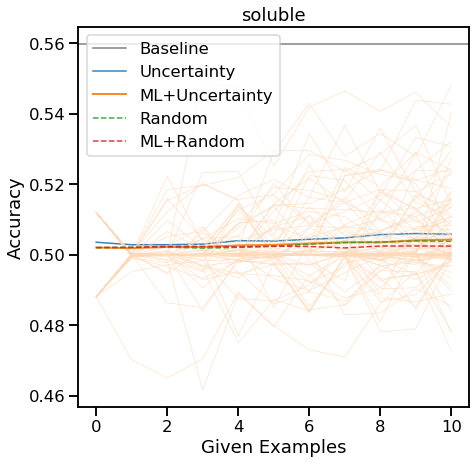

In [65]:
def plot_dataset(ax, ml_location, location, strategy, index, legend=False, ml=True, zoom=False):
    ax.set_title(names[index])
    index = str(index)
    strategy_names = {'umin': 'Uncertainty', 'qbc': 'QBC'}
    aucs = []
    aucs.append(plot_condition(ax, 'Baseline', 'gray', '-', os.path.join(location, 'all', index), trace=False, horizontal=True))
    aucs.append(plot_condition(ax, strategy_names[strategy], 'C0', '-', os.path.join(location, strategy, index), trace=not ml))
    if ml:
        aucs.append(plot_condition(ax, 'ML+' + strategy_names[strategy], 'C1', '-', os.path.join(ml_location, strategy, index), trace=True))
    
    aucs.append(plot_condition(ax, 'Random', 'C2', '--', os.path.join(location, 'random', index), trace=False))
    if ml:
        aucs.append(plot_condition(ax, 'ML+Random', 'C3', '--', os.path.join(ml_location, 'random', index), trace=False))
    if zoom:
        ax.set_xlim(0,5)
        #ax.set_ylim(0.45,0.75)
    else:
        pass
        #ax.set_ylim(0.45,1.0)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    
    if legend:
        ax.legend()
        ax.set_xlabel('Given Examples')
        ax.set_ylabel('Accuracy')
    return aucs
plt.figure(figsize=(7,7))
ax = plt.gca()
plot_dataset(ax, 'reptile-models', 'models', 'umin', 8, legend=True, ml=True)
plt.savefig('example.png')

In [66]:
def plot_strategy(ml_location, location, strategy, ml=True, zoom=False, stop=len(names)):
    fig, axs= plt.subplots(nrows=3, ncols=4, figsize=(14,8), sharex=True, sharey=False)
    print('Data Standard'.format(strategy), end='')
    if ml:
        print(' ML+{} ML+Random'.format(strategy))
    else:
        print(' {} Random'.format(strategy))
    for i in range(3):
        for j in range(4):
            k = i * 4 + j
            line = [names[k]] + plot_dataset(axs[i,j], ml_location, location, strategy, k, k == len(names), ml=ml, zoom=zoom)
            if k == 7:
                axs[i,j].legend(loc='upper right', bbox_to_anchor=(2.4, 1.0), fancybox=True, shadow=True, fontsize=10)
            if ml:
                print('{} & ${:.2f}$ & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$'.format(line[0], line[1][0], *line[4], *line[-1]))
            else:
                print('{} & ${:.2f}$ & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$'.format(line[0], line[1][0], *line[2], *line[3]))
    plt.tight_layout()
    plt.savefig('{}{}{}.png'.format(strategy, '-ml' if ml else '', '-zoom' if zoom else ''), dpi=300)

Data Standard ML+umin ML+Random
antibacterial & $0.81$ & $0.75 \pm 0.14$ & $0.66 \pm 0.23$
anticancer & $0.80$ & $0.74 \pm 0.16$ & $0.72 \pm 0.23$
antifungal & $0.83$ & $0.75 \pm 0.14$ & $0.67 \pm 0.21$
antiHIV & $0.89$ & $0.74 \pm 0.14$ & $0.67 \pm 0.18$
antiMRSA & $1.00$ & $0.95 \pm 0.13$ & $0.95 \pm 0.17$
antiparasital & $0.87$ & $0.89 \pm 0.17$ & $0.78 \pm 0.17$
antiviral & $0.91$ & $0.72 \pm 0.15$ & $0.62 \pm 0.16$
hemolytic & $0.99$ & $0.72 \pm 0.17$ & $0.72 \pm 0.26$
soluble & $0.62$ & $0.50 \pm 0.02$ & $0.50 \pm 0.03$
shp2 & $0.83$ & $0.50 \pm 0.10$ & $0.50 \pm 0.06$
tula2 & $0.64$ & $0.47 \pm 0.11$ & $0.49 \pm 0.11$
human & $0.89$ & $0.82 \pm 0.13$ & $0.77 \pm 0.20$


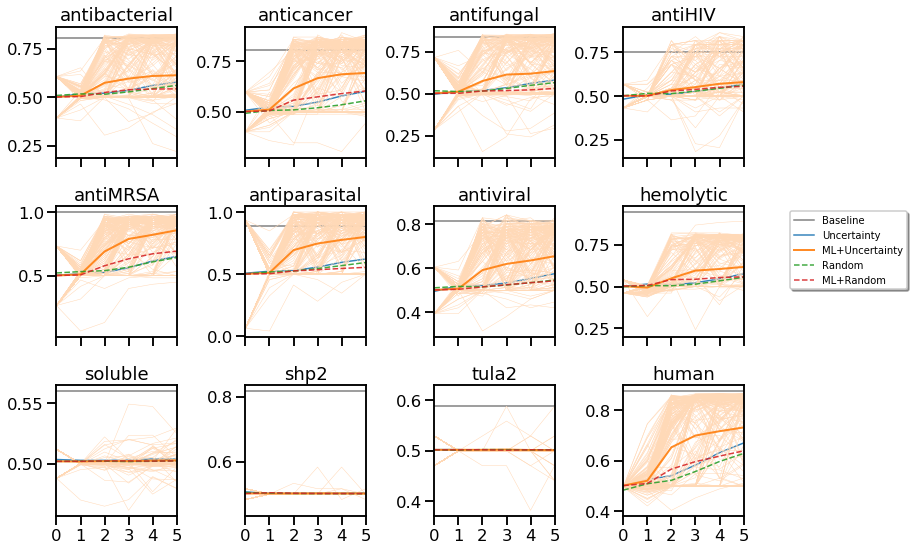

In [67]:
plot_strategy('reptile-models', 'models', 'umin', zoom=True)

Data Standard ML+umin ML+Random
antibacterial & $0.81$ & $0.75 \pm 0.14$ & $0.66 \pm 0.23$
anticancer & $0.80$ & $0.74 \pm 0.16$ & $0.72 \pm 0.23$
antifungal & $0.83$ & $0.75 \pm 0.14$ & $0.67 \pm 0.21$
antiHIV & $0.89$ & $0.74 \pm 0.14$ & $0.67 \pm 0.18$
antiMRSA & $1.00$ & $0.95 \pm 0.13$ & $0.95 \pm 0.17$
antiparasital & $0.87$ & $0.89 \pm 0.17$ & $0.78 \pm 0.17$
antiviral & $0.91$ & $0.72 \pm 0.15$ & $0.62 \pm 0.16$
hemolytic & $0.99$ & $0.72 \pm 0.17$ & $0.72 \pm 0.26$
soluble & $0.62$ & $0.50 \pm 0.02$ & $0.50 \pm 0.03$
shp2 & $0.83$ & $0.50 \pm 0.10$ & $0.50 \pm 0.06$
tula2 & $0.64$ & $0.47 \pm 0.11$ & $0.49 \pm 0.11$
human & $0.89$ & $0.82 \pm 0.13$ & $0.77 \pm 0.20$


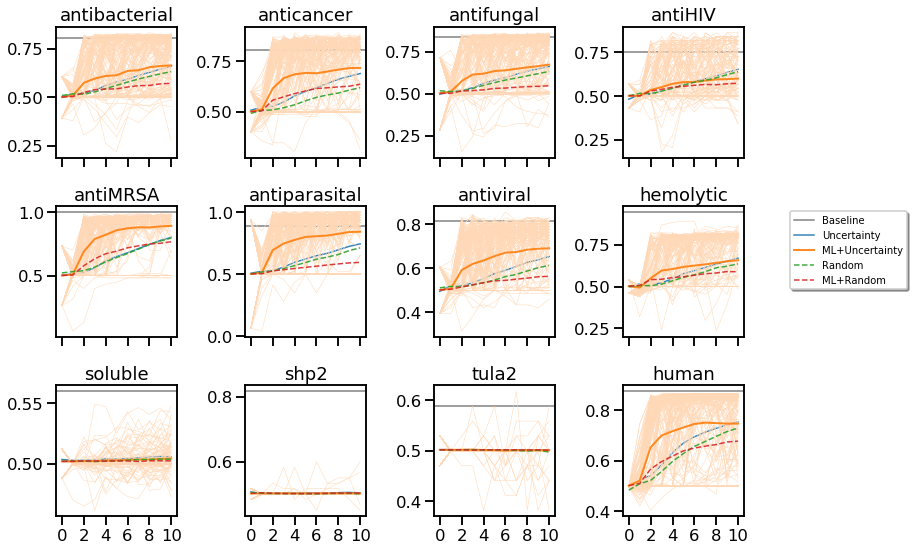

In [68]:
plot_strategy('reptile-models', 'models', 'umin')

Data Standard umin Random
antibacterial & $0.81$ & $0.75 \pm 0.13$ & $0.75 \pm 0.14$
anticancer & $0.80$ & $0.76 \pm 0.14$ & $0.74 \pm 0.16$
antifungal & $0.83$ & $0.76 \pm 0.16$ & $0.75 \pm 0.14$
antiHIV & $0.89$ & $0.75 \pm 0.19$ & $0.74 \pm 0.14$
antiMRSA & $1.00$ & $0.89 \pm 0.14$ & $0.95 \pm 0.13$
antiparasital & $0.87$ & $0.85 \pm 0.17$ & $0.89 \pm 0.17$
antiviral & $0.91$ & $0.75 \pm 0.18$ & $0.72 \pm 0.15$
hemolytic & $0.99$ & $0.74 \pm 0.18$ & $0.72 \pm 0.17$
soluble & $0.62$ & $0.51 \pm 0.02$ & $0.50 \pm 0.02$
shp2 & $0.83$ & $0.51 \pm 0.11$ & $0.50 \pm 0.10$
tula2 & $0.64$ & $0.50 \pm 0.08$ & $0.47 \pm 0.11$
human & $0.89$ & $0.83 \pm 0.09$ & $0.82 \pm 0.13$


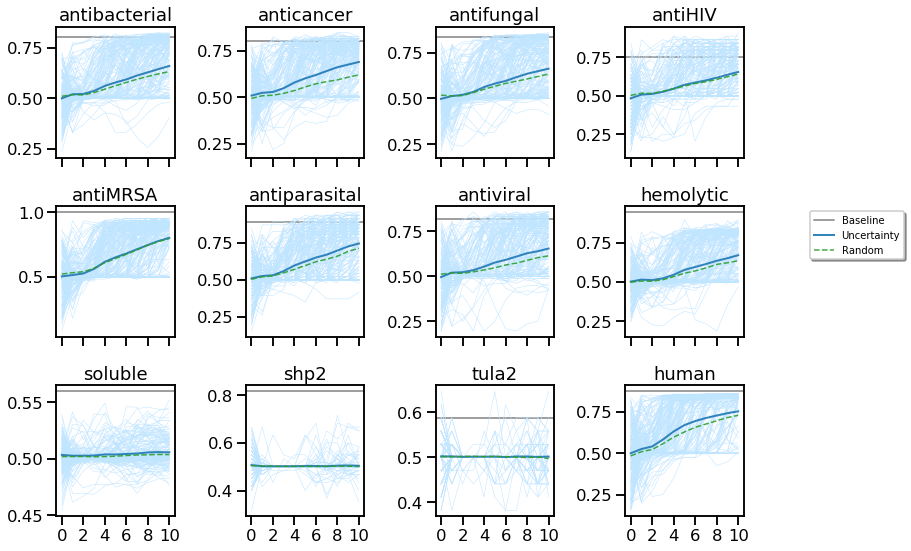

In [69]:
plot_strategy('reptile-models', 'models', 'umin', ml=False)

Data Standard qbc Random
antibacterial & $0.81$ & $0.73 \pm 0.15$ & $0.75 \pm 0.14$
anticancer & $0.80$ & $0.75 \pm 0.13$ & $0.74 \pm 0.16$
antifungal & $0.83$ & $0.73 \pm 0.17$ & $0.75 \pm 0.14$
antiHIV & $0.89$ & $0.79 \pm 0.14$ & $0.74 \pm 0.14$
antiMRSA & $1.00$ & $0.91 \pm 0.13$ & $0.95 \pm 0.13$
antiparasital & $0.87$ & $0.85 \pm 0.18$ & $0.89 \pm 0.17$
antiviral & $0.91$ & $0.75 \pm 0.19$ & $0.72 \pm 0.15$
hemolytic & $0.99$ & $0.78 \pm 0.16$ & $0.72 \pm 0.17$
soluble & $0.62$ & $0.51 \pm 0.02$ & $0.50 \pm 0.02$
shp2 & $0.83$ & $0.51 \pm 0.09$ & $0.50 \pm 0.10$
tula2 & $0.64$ & $0.49 \pm 0.08$ & $0.47 \pm 0.11$
human & $0.89$ & $0.84 \pm 0.08$ & $0.82 \pm 0.13$


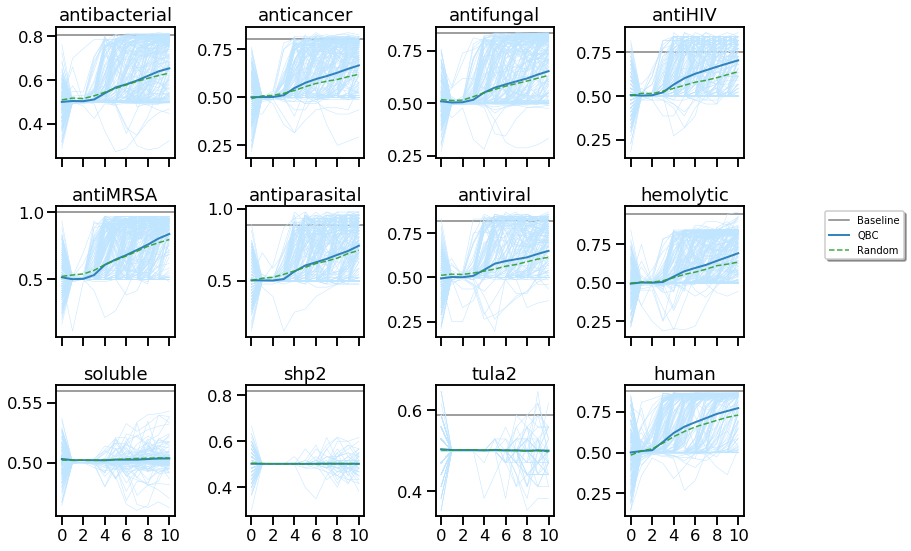

In [70]:
plot_strategy('reptile-weights', 'models', 'qbc', ml=False)

Data Standard ML+qbc ML+Random
antibacterial & $0.81$ & $0.75 \pm 0.14$ & $0.66 \pm 0.23$
anticancer & $0.80$ & $0.74 \pm 0.16$ & $0.72 \pm 0.23$
antifungal & $0.83$ & $0.75 \pm 0.14$ & $0.67 \pm 0.21$
antiHIV & $0.89$ & $0.74 \pm 0.14$ & $0.67 \pm 0.18$
antiMRSA & $1.00$ & $0.95 \pm 0.13$ & $0.95 \pm 0.17$
antiparasital & $0.87$ & $0.89 \pm 0.17$ & $0.78 \pm 0.17$
antiviral & $0.91$ & $0.72 \pm 0.15$ & $0.62 \pm 0.16$
hemolytic & $0.99$ & $0.72 \pm 0.17$ & $0.72 \pm 0.26$
soluble & $0.62$ & $0.50 \pm 0.02$ & $0.50 \pm 0.03$
shp2 & $0.83$ & $0.50 \pm 0.10$ & $0.50 \pm 0.06$
tula2 & $0.64$ & $0.47 \pm 0.11$ & $0.49 \pm 0.11$
human & $0.89$ & $0.82 \pm 0.13$ & $0.77 \pm 0.20$


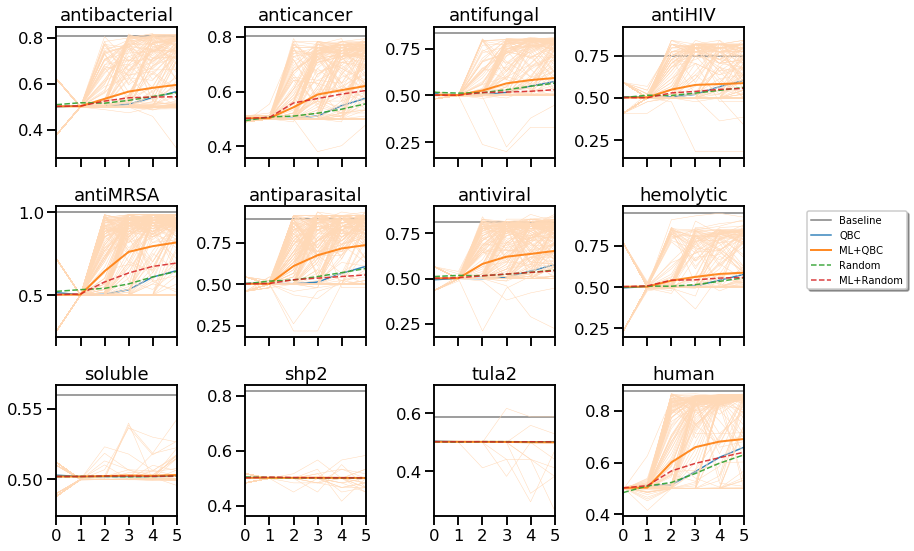

In [71]:
plot_strategy('reptile-models', 'models', 'qbc', ml=True, zoom=True)

Data Standard ML+qbc ML+Random
antibacterial & $0.81$ & $0.75 \pm 0.14$ & $0.66 \pm 0.23$
anticancer & $0.80$ & $0.74 \pm 0.16$ & $0.72 \pm 0.23$
antifungal & $0.83$ & $0.75 \pm 0.14$ & $0.67 \pm 0.21$
antiHIV & $0.89$ & $0.74 \pm 0.14$ & $0.67 \pm 0.18$
antiMRSA & $1.00$ & $0.95 \pm 0.13$ & $0.95 \pm 0.17$
antiparasital & $0.87$ & $0.89 \pm 0.17$ & $0.78 \pm 0.17$
antiviral & $0.91$ & $0.72 \pm 0.15$ & $0.62 \pm 0.16$
hemolytic & $0.99$ & $0.72 \pm 0.17$ & $0.72 \pm 0.26$
soluble & $0.62$ & $0.50 \pm 0.02$ & $0.50 \pm 0.03$
shp2 & $0.83$ & $0.50 \pm 0.10$ & $0.50 \pm 0.06$
tula2 & $0.64$ & $0.47 \pm 0.11$ & $0.49 \pm 0.11$
human & $0.89$ & $0.82 \pm 0.13$ & $0.77 \pm 0.20$


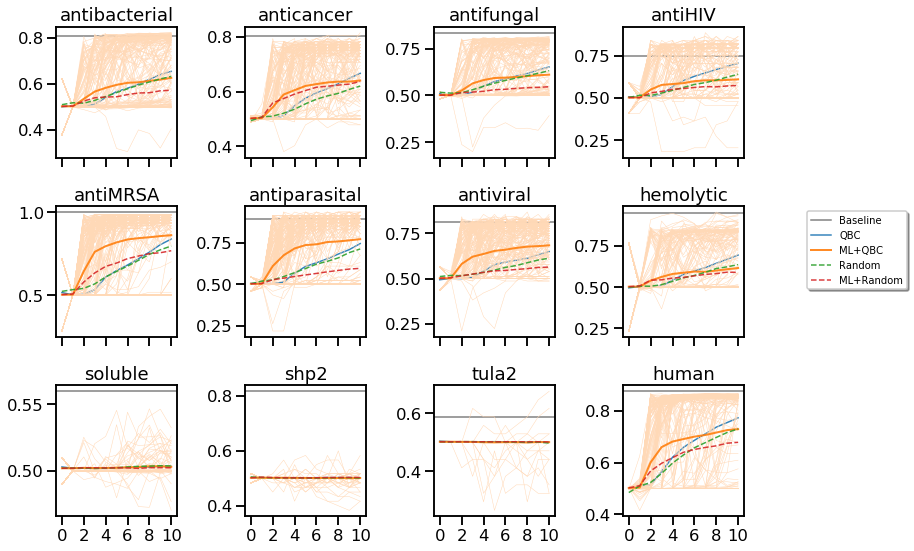

In [101]:
plot_strategy('reptile-models', 'models', 'qbc', ml=True)

In [311]:
ALPHABET = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']

def decode_motif(array):
    return ''.join([ALPHABET[int(i)] for i in array])

def mode(motifs):
    '''
    computes mode
    '''
    motifs.sort()
    last = motifs[0]
    mode,mode_count,count = last,1,1
    for m in motifs[1:]:
        if m == last:
            count += 1
        elif count >= mode_count:
            mode = last
            mode_count = count
            count = 1
        else:
            count = 1
        last = m
    if count >= mode_count:
        mode = last
        mode_count = count
    return (mode, mode_count)
print(mode(['GGG', 'GGG', 'ERG', 'DFH']))
print(mode(['GGG', 'GGG', 'ERG', 'DFH', 'DFH']))
print(mode(['GGG', 'GGG', 'ERG', 'DFH', 'DFH', 'DFH']))

('GGG', 2)
('GGG', 2)
('DFH', 3)


In [324]:
def get_motifs(location):
    motifs = []
    for i in range(250):
        motif_path = '{}/{}_motifs.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(motif_path):
            break
        m = np.genfromtxt(motif_path)
        # sort them so we can get around lack of ordering. 
        motifs.append([decode_motif(mi) for mi in m])
        motifs[-1].sort()
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + motif_path)
    # now we need to histogram them
    motif_modes = []
    for i in range(len(motifs[0])):
        motif_modes.append(mode([m[i] for m in motifs]))
    # sort them
    motif_modes.sort(key = lambda x: x[1])
    return motif_modes
get_motifs('models/all/1')

[('FETNSS', 1), ('HNIEDP', 1), ('WADPIN', 1), ('LADMIN', 2), ('WAIMRQ', 3)]

In [373]:
def get_count_grads(location):
    count_grads = []
    for i in range(250):
        path = '{}/{}_count_grads.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(path):
            break
        m = np.genfromtxt(path)
        count_grads.append(m)
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + path)
    # now we need to histogram them
    print(count_grads[8])
    return np.mean(count_grads, axis=0)
get_count_grads('models/all/0')

[6.44606633e-04 2.07243039e-04 2.77566801e-04 3.54131787e-04
 2.58750311e-04 5.64245726e-07 3.82683655e-04 3.90221608e-04
 7.22381901e-05 4.04931824e-04 1.30044401e-04 2.70897293e-04
 2.62411873e-04 2.55757040e-04 3.81752915e-04 2.36119966e-04
 3.73984062e-04 1.72673079e-04 3.11444347e-04 2.32841822e-04
 2.93024572e-04]


array([1.65760875e-02, 5.24345788e-03, 9.35771383e-03, 8.07318361e-03,
       7.38263266e-03, 6.91091223e-05, 7.25924071e-03, 9.14638607e-03,
       9.35249419e-03, 1.03530983e-02, 8.56656630e-03, 7.71650453e-03,
       6.59341878e-03, 5.71003698e-03, 8.14960955e-03, 7.61494268e-03,
       7.69308457e-03, 4.55169894e-03, 3.77002831e-03, 6.24990404e-03,
       7.06141245e-03])

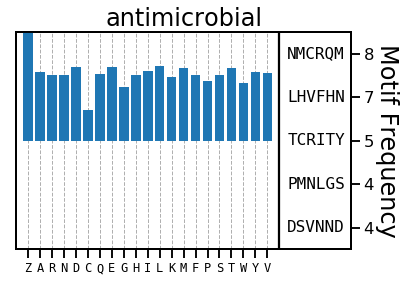

In [352]:
def plot_explain(location, name, motif_width=6, ax=None, labelx = True, labely_left = True, labely_right = True):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.grid(linewidth=1, linestyle='--', zorder=1)
    
    cg = get_count_grads(location)
    # make y-axis symmetric
    ymax = max(abs(min(cg)), abs(max(cg)))
    ax.set_ylim(-ymax, ymax)
    x = list(range(len(cg)))
    ax.bar(x, height=cg, zorder=99)
    ax.set_yticks([])
    if labelx:
        ax.set_xticks(x + [x[-1] + 1 + motif_width // 2])
        ax.set_xticklabels(['Z'] + ALPHABET + ['Motifs'], fontdict={'size': 18, 'family': 'monospace'})
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(['Z'] + ALPHABET, fontdict={'size': 12, 'family': 'monospace'})
    if labely_left:
        ax.set_ylabel('Class Effect', fontsize=24)
    ax.set_xlim(-1,x[-1] + 1 + motif_width)
    ax.axvline(x[-1] + 1, color='black')
    ax2 = ax.twinx()
    motifs = get_motifs(location)
    yticks = []
    for i,m in enumerate(motifs):
        y = i + 0.5
        yticks.append(y)
        ax2.text(x[-1] + 0.5 + motif_width, y, verticalalignment='center', 
                s=motifs[i][0], fontdict={'size': 16, 'family': 'monospace'},
               horizontalalignment='right')
    ax2.set_ylim(0,len(motifs))
    ax2.set_yticks(yticks)
    ax2.set_yticklabels([m[1] for m in motifs])
    if labely_right:
        ax2.yaxis.set_label_position('right')
        ax2.set_ylabel('Motif Frequency', rotation=-90, labelpad=25, fontsize=24)
    ax.set_title(name, fontsize=24)
plot_explain('models/all/0', 'antimicrobial', labely_left=False, labelx=False)
#plt.tight_layout()
plt.show()

In [350]:
def plot_interpret(location_root, strategy):
    fig, axs= plt.subplots(nrows=3, ncols=4, figsize=(28,16), sharex=False, sharey=False)
    for i in range(3):
        for j in range(4):
            k = i * 4 + j
            plot_explain(os.path.join(location_root, strategy, str(k)), 
                         names[k], ax=axs[i,j], labelx = i == 2, labely_right = j == 3,
                         labely_left = j == 0)
    #plt.savefig('interpret-{}.png'.format(strategy), dpi=300)
    plt.show()

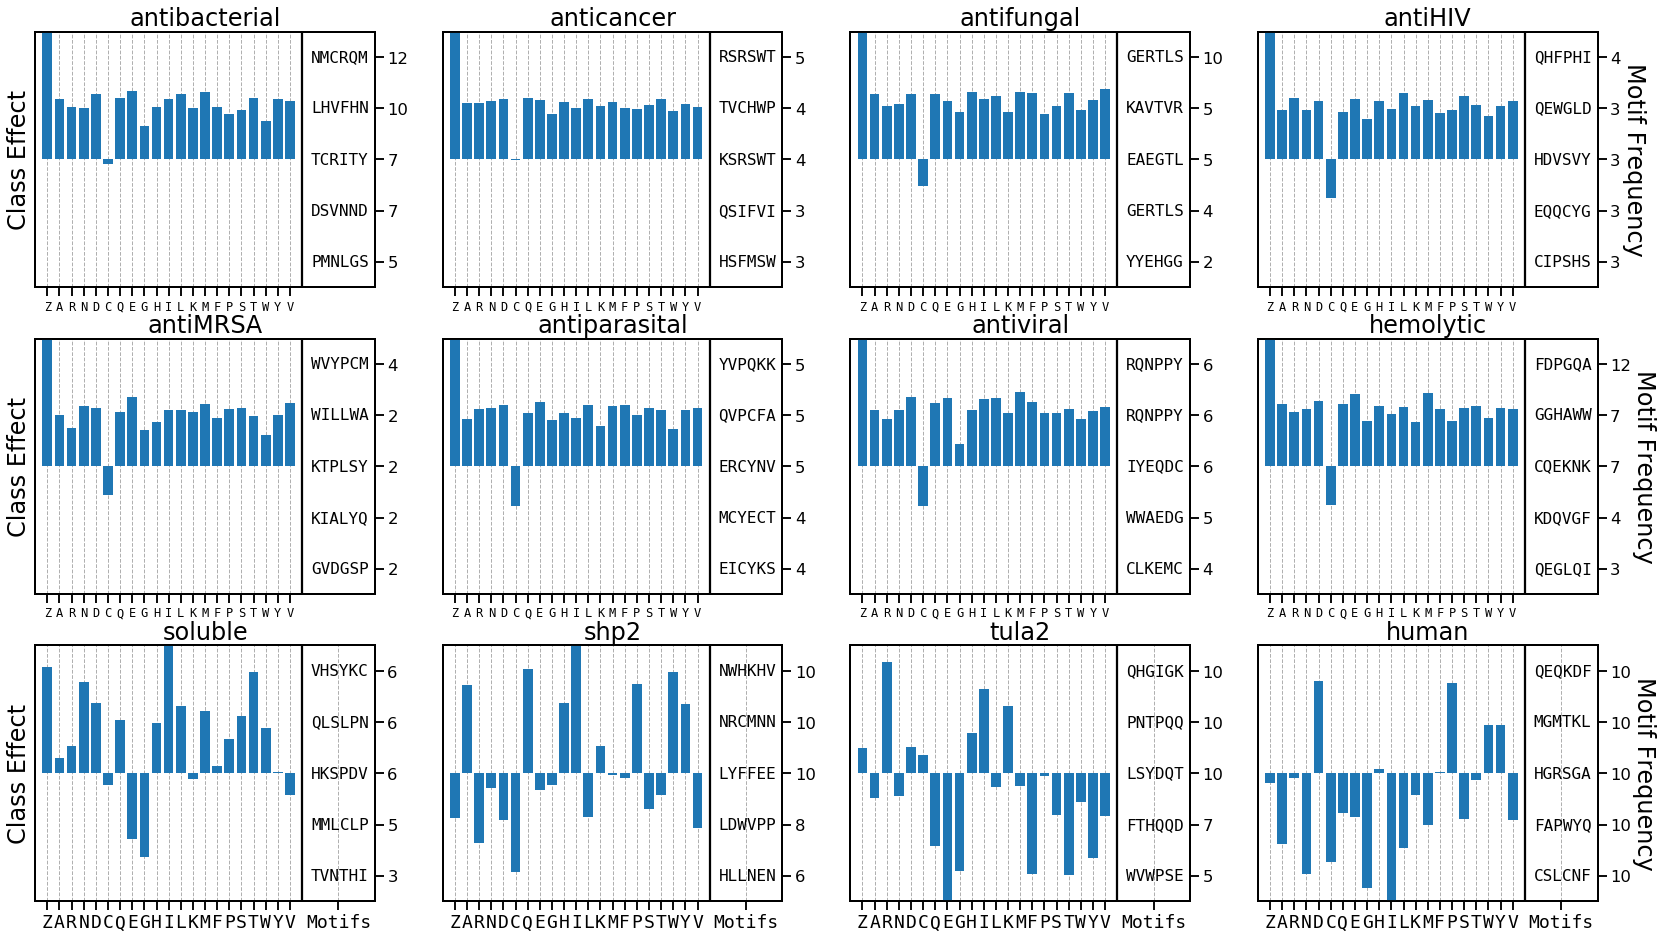

In [351]:
plot_interpret('models', 'all')

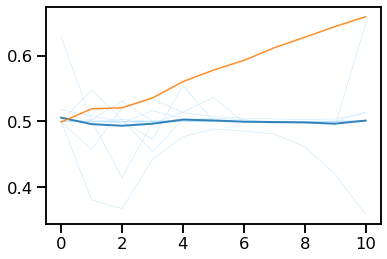

In [333]:
plt.figure()
ax = plt.gca()
plot_condition(ax, 'foo', 'C0', '-', 'test-models/umin/0/', trace=True)
plot_condition(ax, 'foo', 'C1', '-', 'models/umin/0/', trace=False)
plt.show()